In [155]:
import scipy.io as sio
import numpy
import scipy
import numpy as np 
import time 
from scipy.signal import savgol_filter,find_peaks
from scipy.interpolate import splev, splrep, InterpolatedUnivariateSpline 
from pyfsi.fsiEnums import * 
from pyfsi.fsiExceptions import *
import csv
import math
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook   
from lmfit.models import LorentzianModel
from scipy.signal import savgol_filter
import logging
import pyfsi.fsiInitConfiguration as initCfg
import cupy as cp
import cupyx.scipy.linalg
import cusignal
from math import factorial

In [156]:
'Steps for Linearizing the data'

'Steps for Linearizing the data'

In [157]:
'Linear Filter on GPU'

def ndim(self):
        return len(self._shape)
    
    
    
def _validate_x(x):
    x = cp.asarray(x)
    if x.ndim == 0:
        raise ValueError('x must be at least 1-D')
    return x

def lfilter(b, a, x, axis=-1, zi=None):
    """
    Filter data along one-dimension with an IIR or FIR filter.
    Filter a data sequence, `x`, using a digital filter.  This works for many
    fundamental data types (including Object type).  The filter is a direct
    form II transposed implementation of the standard difference equation
    (see Notes).
    The function `sosfilt` (and filter design using ``output='sos'``) should be
    preferred over `lfilter` for most filtering tasks, as second-order sections
    have fewer numerical problems.
    Parameters
    ----------
    b : array_like
        The numerator coefficient vector in a 1-D sequence.
    a : array_like
        The denominator coefficient vector in a 1-D sequence.  If ``a[0]``
        is not 1, then both `a` and `b` are normalized by ``a[0]``.
    x : array_like
        An N-dimensional input array.
    axis : int, optional
        The axis of the input data array along which to apply the
        linear filter. The filter is applied to each subarray along
        this axis.  Default is -1.
    zi : array_like, optional
        Initial conditions for the filter delays.  It is a vector
        (or array of vectors for an N-dimensional input) of length
        ``max(len(a), len(b)) - 1``.  If `zi` is None or is not given then
        initial rest is assumed.  See `lfiltic` for more information.
    Returns
    -------
    y : array
        The output of the digital filter.
    zf : array, optional
        If `zi` is None, this is not returned, otherwise, `zf` holds the
        final filter delay values.
    
    
    """
    
    
    a = cp.atleast_1d(a)
   
    if len(a) != 1:
        # This path only supports types fdgFDGO to mirror _linear_filter below.
        # Any of b, a, x, or zi can set the dtype, but there is no default
        # casting of other types; instead a NotImplementedError is raised.
        b = cp.asarray(b)
       
        
        a = cp.asarray(a)
        if b.ndim != 1 and a.ndim != 1:
            raise ValueError('object of too small depth for desired array')
        x = _validate_x(x)
        inputs = [b, a, x]
        if zi is not None:
            # _linear_filter does not broadcast zi, but does do expansion of
            # singleton dims.
            zi = cp.asarray(zi)
            if zi.ndim != x.ndim:
                raise ValueError('object of too small depth for desired array')
            expected_shape = list(x.shape)
            expected_shape[axis] = b.shape[0] - 1
            expected_shape = tuple(expected_shape)
            # check the trivial case where zi is the right shape first
            if zi.shape != expected_shape:
                strides = zi.ndim * [None]
                if axis < 0:
                    axis += zi.ndim
                for k in range(zi.ndim):
                    if k == axis and zi.shape[k] == expected_shape[k]:
                        strides[k] = zi.strides[k]
                    elif k != axis and zi.shape[k] == expected_shape[k]:
                        strides[k] = zi.strides[k]
                    elif k != axis and zi.shape[k] == 1:
                        strides[k] = 0
                    else:
                        raise ValueError('Unexpected shape for zi: expected '
                                         '%s, found %s.' %
                                         (expected_shape, zi.shape))
                zi = cp.lib.stride_tricks.as_strided(zi, expected_shape,
                                                     strides)
            inputs.append(zi)
        dtype = cp.result_type(*inputs)
        
        if dtype.char not in 'fdgFDGO':
            raise NotImplementedError("input type '%s' not supported" % dtype)

        b = cp.array(b, dtype=dtype)
        a = cp.array(a, dtype=dtype, copy=False)
        b /= a[0]
        x = cp.array(x, dtype=dtype, copy=False)

        out_full = cp.apply_along_axis(lambda y: cp.convolve(b, y), axis, x)
        ind = out_full.ndim * [slice(None)]
        if zi is not None:
            ind[axis] = slice(zi.shape[axis])
            out_full[tuple(ind)] += zi

        ind[axis] = slice(out_full.shape[axis] - len(b) + 1)
        out = out_full[tuple(ind)]
        if zi is None:
            return out
        else:
            ind[axis] = slice(out_full.shape[axis] - len(b) + 1, None)
            zf = out_full[tuple(ind)]
            return out, zf
        

In [158]:
'GPU Butter Filter'

def buttap(N):
    """Return (z,p,k) for analog prototype of Nth-order Butterworth filter.
    The filter will have an angular (e.g., rad/s) cutoff frequency of 1.
    See Also
    --------
    butter : Filter design function using this prototype
    """
    pi =3.14
    if abs(int(N)) != N:
        raise ValueError("Filter order must be a nonnegative integer")
    z = cp.array([])
    m = cp.arange(-N+1, N, 2)
    # Middle value is 0 to ensure an exactly real pole
    p = -cp.exp(1j * pi * m / (2 * N))
    k = 1
    return z, p, k


pi=3.14

filter_dict = {'butter': [buttap],
               'butterworth': [buttap],
               }

band_dict = {'band': 'bandpass',
             'bandpass': 'bandpass',
             'pass': 'bandpass',
             'bp': 'bandpass',

             'bs': 'bandstop',
             'bandstop': 'bandstop',
             'bands': 'bandstop',
             'stop': 'bandstop',

             'l': 'lowpass',
             'low': 'lowpass',
             'lowpass': 'lowpass',
             'lp': 'lowpass',

             'high': 'highpass',
             'highpass': 'highpass',
             'h': 'highpass',
             'hp': 'highpass',
             }


def _relative_degree(z, p):
    """
    Return relative degree of transfer function from zeros and poles
    """
    degree = len(p) - len(z)
    if degree < 0:
        raise ValueError("Improper transfer function. "
                         "Must have at least as many poles as zeros.")
    else:
        return degree
    
    
    
def bilinear_zpk(z, p, k, fs):
    
    z = cp.atleast_1d(z)
    p = cp.atleast_1d(p)

    degree = _relative_degree(z, p)

    fs2 = 2.0*fs

    # Bilinear transform the poles and zeros
    z_z = (fs2 + z) / (fs2 - z)
    p_z = (fs2 + p) / (fs2 - p)

    # Any zeros that were at infinity get moved to the Nyquist frequency
    z_z = cp.append(z_z, -cp.ones(degree))

    # Compensate for gain change
    k_z = k * cp.real(cp.prod(fs2 - z) / cp.prod(fs2 - p))

    return z_z, p_z, k_z


def zpk2tf(z, p, k):
    
    z = cp.asnumpy(z)
    p = cp.asnumpy(p)
    k = cp.asnumpy(k)
    
    z = np.atleast_1d(z)
    k = np.atleast_1d(k)

    
    if len(z.shape) > 1:
        temp = np.poly(z[0])
        print(z[0])
        b = np.empty((z.shape[0], z.shape[1] + 1), temp.dtype.char)
        if len(k) == 1:
            k = [k[0]] * z.shape[0]
        for i in range(z.shape[0]):
            b[i] = k[i] * np.poly(z[i])
    else:
        b = k * np.poly(z)
    a = np.atleast_1d(np.poly(p))

    # Use real output if possible. Copied from numpy.poly, since
    # we can't depend on a specific version of numpy.
    if issubclass(b.dtype.type, numpy.complexfloating):
        # if complex roots are all complex conjugates, the roots are real.
        roots = numpy.asarray(z, complex)
        pos_roots = numpy.compress(roots.imag > 0, roots)
        neg_roots = numpy.conjugate(numpy.compress(roots.imag < 0, roots))
        if len(pos_roots) == len(neg_roots):
            if numpy.all(numpy.sort_complex(neg_roots) ==
                         numpy.sort_complex(pos_roots)):
                b = b.real.copy()

    if issubclass(a.dtype.type, numpy.complexfloating):
        # if complex roots are all complex conjugates, the roots are real.
        roots = numpy.asarray(p, complex)
        pos_roots = numpy.compress(roots.imag > 0, roots)
        neg_roots = numpy.conjugate(numpy.compress(roots.imag < 0, roots))
        if len(pos_roots) == len(neg_roots):
            if numpy.all(numpy.sort_complex(neg_roots) ==
                         numpy.sort_complex(pos_roots)):
                a = a.real.copy()

    return b, a

def lp2lp_zpk(z, p, k, wo=1.0):
    """
    Transform a lowpass filter prototype to a different frequency.
    Return an analog low-pass filter with cutoff frequency `wo`
    from an analog low-pass filter prototype with unity cutoff frequency,
    using zeros, poles, and gain ('zpk') representation.
    Parameters
    ----------
    z : array_like
        Zeros of the analog filter transfer function.
    p : array_like
        Poles of the analog filter transfer function.
    k : float
        System gain of the analog filter transfer function.
    wo : float
        Desired cutoff, as angular frequency (e.g., rad/s).
        Defaults to no change.
    Returns
    -------
    z : ndarray
        Zeros of the transformed low-pass filter transfer function.
    p : ndarray
        Poles of the transformed low-pass filter transfer function.
    k : float
        System gain of the transformed low-pass filter.
    
    """
    z = cp.atleast_1d(z)
    p = cp.atleast_1d(p)
    wo = float(wo)  # Avoid int wraparound

    degree = _relative_degree(z, p)

    # Scale all points radially from origin to shift cutoff frequency
    z_lp = wo * z
    p_lp = wo * p

    # Each shifted pole decreases gain by wo, each shifted zero increases it.
    # Cancel out the net change to keep overall gain the same
    k_lp = k * wo**degree

    return z_lp, p_lp, k_lp
  
    

def lp2hp_zpk(z, p, k, wo=1.0):
    """
    Transform a lowpass filter prototype to a highpass filter.
    Return an analog high-pass filter with cutoff frequency `wo`
    from an analog low-pass filter prototype with unity cutoff frequency,
    using zeros, poles, and gain ('zpk') representation.
    Parameters
    ----------
    z : array_like
        Zeros of the analog filter transfer function.
    p : array_like
        Poles of the analog filter transfer function.
    k : float
        System gain of the analog filter transfer function.
    wo : float
        Desired cutoff, as angular frequency (e.g., rad/s).
        Defaults to no change.
    Returns
    -------
    z : ndarray
        Zeros of the transformed high-pass filter transfer function.
    p : ndarray
        Poles of the transformed high-pass filter transfer function.
    k : float
        System gain of the transformed high-pass filter.
    
    """
    z = cp.atleast_1d(z)
    p = cp.atleast_1d(p)
    wo = float(wo)

    degree = _relative_degree(z, p)

    # Invert positions radially about unit circle to convert LPF to HPF
    # Scale all points radially from origin to shift cutoff frequency
    z_hp = wo / z
    p_hp = wo / p

    # If lowpass had zeros at infinity, inverting moves them to origin.
    z_hp = cp.append(z_hp, cp.zeros(degree))

    # Cancel out gain change caused by inversion
    k_hp = k * cp.real(cp.prod(-z) / cp.prod(-p))

    return z_hp, p_hp, k_hp
    

def iirfilter(N, Wn, rp=None, rs=None, btype='band', analog=False,
              ftype='butter', output='ba', fs=None):
    
    ftype, btype, output = [x.lower() for x in (ftype, btype, output)]
    Wn = cp.asarray(Wn)
    if fs is not None:
        if analog:
            raise ValueError("fs cannot be specified for an analog filter")
        Wn = 2*Wn/fs

    try:
        btype = band_dict[btype]
    except KeyError as e:
        raise ValueError("'%s' is an invalid bandtype for filter." % btype) from e

    try:
        typefunc = filter_dict[ftype][0]
    except KeyError as e:
        raise ValueError("'%s' is not a valid basic IIR filter." % ftype) from e

    if output not in ['ba', 'zpk']:
        raise ValueError("'%s' is not a valid output form." % output)

    if rp is not None and rp < 0:
        raise ValueError("passband ripple (rp) must be positive")

    if rs is not None and rs < 0:
        raise ValueError("stopband attenuation (rs) must be positive")

    # Get analog lowpass prototype
    if typefunc == buttap:
        z, p, k = typefunc(N)
    else:
        raise NotImplementedError("'%s' not implemented in iirfilter." % ftype)

    # Pre-warp frequencies for digital filter design
    if not analog:
        if cp.any(Wn <= 0) or cp.any(Wn >= 1):
            if fs is not None:
                raise ValueError("Digital filter critical frequencies "
                                 "must be 0 < Wn < fs/2 (fs={} -> fs/2={})".format(fs, fs/2))
            raise ValueError("Digital filter critical frequencies "
                             "must be 0 < Wn < 1")
        fs = 2.0
        warped = 2 * fs * cp.tan(pi * Wn / fs)
    else:
        warped = Wn

    # transform to lowpass, bandpass, highpass, or bandstop
    if btype in ('lowpass', 'highpass'):
        if btype == 'lowpass':
            z, p, k = lp2lp_zpk(z, p, k, wo=warped)
            
        elif btype == 'highpass':
            z, p, k = lp2hp_zpk(z, p, k, wo=warped)
    else:
        raise NotImplementedError("'%s' not implemented in iirfilter." % btype)

    # Find discrete equivalent if necessary
    if not analog:
       z, p, k = bilinear_zpk(z, p, k, fs=fs)
  
    # Transform to proper out type (pole-zero, state-space, numer-denom)
    if output == 'zpk':
        return z, p, k
    elif output == 'ba':
        return zpk2tf(z, p, k)
    
def butter(N, Wn, btype='low', analog=False, output='ba', fs=None):
    
    return iirfilter(N, Wn, btype=btype, analog=analog,
                     output=output, ftype='butter', fs=fs)


In [159]:
'Butterworth high pass filter'

def butter_highpass(cutoff, fs, order):
    """
    Create a Butterworth Highpass filter, according to specified parameters.

    Keyword arguments:
    ------------------
    cutoff  -- cutoff frequency
    fs      -- sampling frequency
    order   -- filter order

    Return:
    -------
    Filter coefficients b and a.
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a



def filterDataButterworthHighpass(data, cutoff, fs):
    """
    Apply a Butterworth highpass filter to the input data.

    Keyword arguments:
    ------------------
    data -- input data to be filtered
    cutoff -- cutoff frequency
    fs -- sampling frequency

    Return:
    -------
    Filtered data
    """
    b, a = butter_highpass(cutoff, fs, order=2)  # Order shouldnt't be too big!
    ret = lfilter(b, a, data)
    ret = cp.asnumpy(ret)
    return ret


'Hilbert Transform in GPU'

def ndim(self):
        return len(self._shape)
    
def hilbert(x, N=None, axis=-1):
    x = cp.asarray(x)
    if cp.iscomplexobj(x):
        raise ValueError("x must be real.")
    if N is None:
        N = x.shape[axis]
    if N <= 0:
        raise ValueError("N must be positive.")

    Xf = cupyx.scipy.fft.fft(x, N, axis=axis)
    h = cp.zeros(N)
    if N % 2 == 0:
        h[0] = h[N // 2] = 1
        h[1:N // 2] = 2
    else:
        h[0] = 1
        h[1:(N + 1) // 2] = 2

    if x.ndim > 1:
        ind = [np.newaxis] * x.ndim
        ind[axis] = slice(None)
        h = h[tuple(ind)]
    x = cupyx.scipy.fft.ifft(Xf * h, axis=axis)
    return x


def DataLinearize(Tinterval, REF_IFM, GAS_CELL, MEAS) :
    """
    Data linearisation using the reference interferometer data

    Keyword arguments:
    ------------------
    Tinterval   -- sample spacing in seconds
    REF_IFM     -- reference interferometer raw data
    GAS_CELL    -- gas cell raw data
    MEAS        -- measurement interferometer raw data
    
    Return:
    -------
    GAS_CELL_out    -- linearized gas cell data
    MEAS_out        -- linearized measurement interferometer data
    """

    
    fs = 1/Tinterval
    REF_IFM = filterDataButterworthHighpass(REF_IFM, 100000, fs) 
    t = cp.linspace(0.0, len(REF_IFM)*Tinterval, num=len(REF_IFM))

    analytic_signal = hilbert(REF_IFM, axis=0)
    phase = cp.angle(analytic_signal) 
    instantaneous_phase = cp.unwrap(phase, axis=0)
    
    instantaneous_phase = cp.asnumpy(instantaneous_phase)

    
    f_theor = cp.max(instantaneous_phase)/(2*3.14*(Tinterval*len(instantaneous_phase)))
    t_simu = cp.array(instantaneous_phase/(2*3.14*f_theor))
    t_simu[0] = 0                                            # Otherwise the first value of t is below the interpolation range
    t_simu=cp.abs(t_simu)                                       
    t_simu.sort()


    t_simu = cp.array(t_simu)
    MEAS = cp.array(MEAS)
    GAS_CELL= cp.array(GAS_CELL)
    MEAS_out = cp.interp(t, t_simu, MEAS)
    GAS_CELL_out = cp.interp(t, t_simu, GAS_CELL)
    
    
    return GAS_CELL_out, MEAS_out



In [160]:
'Steps for Finding Gas Cell Peaks'

'Steps for Finding Gas Cell Peaks'

In [161]:
'Gas Cell Peak Detection on CPU'


def determineSamplingRate(picoParams):
    """
    Determines the PicoScope sampling rate based on the PICO_RANGE-type timebase.
    For reference on '3403D' model see PicoScope 3000a Series Programmer's Guide -  ps3000apg.en r14 - page 8
    For reference on '4824' model see PicoScope 4000a Series Programmer's Guide -  ps4000apg.en r5 - page 17

    Arguments:
    ------------------
    picoParams -- PicoScope configuratio class

    Return:
    -------
    Sampling rate in samples per second
    """
    samplingRate = 0
    if (picoParams.PICO_MODEL == '3403D'):
        if(picoParams.PICO_SAMPLING_RATE == SAMPLING_RATE.R250MSPS):
            samplingRate = 1e9 / pow(2, picoParams.PICO_SAMPLING_RATE)
        else:
            samplingRate = 125e6 / (picoParams.PICO_SAMPLING_RATE - 2)

    elif(picoParams.PICO_MODEL == '4824'):
        samplingRate = 8e7 / (1 + picoParams.PICO_SAMPLING_RATE)
    
    return samplingRate


def gasCellFittingValidator(errorData):
    '''
    Validating function used to verify the gas cell fitting algorithm. The laser sweep speed is not uniform throughout the sweep
    therefore some fitting errors may occur during the wavelength correction. If this function returns 'False' while the manual 
    verification shows that the fitting is correct increase the validationThreshold.

    Argument:
    ---------
    errorData - differences between the theoretical peak occurence times and occurence times determined by the fitting algorithm

    Return:
    -------
    ret - True gas cell fitting correct, False - measurement data may not be reliable, check the fitting manually
    '''
    validationThreshold = 1e4
    ret = True
    for i in range(0, len(errorData)-2):
        if((np.abs(errorData[i]-errorData[i+1])) > validationThreshold):
            ret = False
    return ret


def gasCellFindPeaks(filteredGasCellData, picoParams, laserParams, wavelengthListPath):
    """
    New peak identifying algorithm for the HCN gas cell fitting. Supposed o be more robust and noise immune.
    Use this instead of gasCellFindPeaksBeta_old
    First, it calulates the theoretical peak positions, based on the NIST wavelength data
    Later, identifies the delay of the sweep start, which for the TLM-8700 laser is usually around ~200 us, and applies a correction to the theoretical peak positions
    Finally it windows the signal around each theoretical peak position and finds the signal maximum.

    Keyword arguments:
    ------------------
    filteredGasCellData -- filtered gas cell signal
    picoParams          -- PicoScope settings, PicoScopeInitParams-type
    laserParams         -- laser settings, LaserInitParams-type
    wavelengthListPath  -- path to the NIST data for the HCN cell (SRM2519a.csv)
    
    Return:
    -------
    An array with identified peak positions (indexes) and warning message if applicable
    """
    nonlinearityCorrectionFactor = 1.5 # Used to account for the nonlinearity of laser sweep speed - empirically determined value!
    peaksFoundIdxs = np.array([])
    wavelengthList = np.genfromtxt(wavelengthListPath)
    samplingRate = determineSamplingRate(picoParams)
    theorPeakIdxs = ((wavelengthList-laserParams.START)/laserParams.SCAN_SPEED)*samplingRate # Calculation of theoretical peaks positions
    
    initialFitProminence = np.abs(np.min(filteredGasCellData)-np.max(filteredGasCellData))/10 # Prominence for initial fitting depands on the signal level
    retStatus = {'Message':'OK', 'Problem':''} # Returned status information

    # Defining the sweep start delay
    maxFilteredGasCellData = np.max(filteredGasCellData)
    minFilteredGasCellData = np.min(filteredGasCellData)
    signalTreshold = (minFilteredGasCellData + 0.33*(np.abs(minFilteredGasCellData) + np.abs(maxFilteredGasCellData)))
    deltaPeakIdxs = theorPeakIdxs[27] - theorPeakIdxs[26]   # Theoretical distance between peak 0 of R branch an peak 1 of P branch
    maxDeltaPeakIdxs = deltaPeakIdxs + 0.01*deltaPeakIdxs   # Upper distance margin for peak search
    minDeltaPeakIdxs = deltaPeakIdxs - 0.01*deltaPeakIdxs   # Lower distance margin for peak search

    initialPeakIdxs, _ = find_peaks(filteredGasCellData, prominence=initialFitProminence, height=signalTreshold, distance=1000) # Initial peak search - supposed to find peaks between the two absorption branches

    # Looking for peak 0 of R branch and peak 1 of P branch
    wavelengthCorrection = 0
    for i in range(0, len(initialPeakIdxs)-1):
        for j in range((i+1), len(initialPeakIdxs)):
            currentdeltaPeakIdxs = initialPeakIdxs[j] - initialPeakIdxs[i]
            if((currentdeltaPeakIdxs >= minDeltaPeakIdxs) and (currentdeltaPeakIdxs <= maxDeltaPeakIdxs)):
                wavelengthCorrection = initialPeakIdxs[i] - theorPeakIdxs[26] # Correction of wavelength corresponding to the delay of sweep start

    theorPeakIdxs = theorPeakIdxs + wavelengthCorrection/nonlinearityCorrectionFactor    # Application of the correction to the theoretical peak positions. The nonlinearityCorrectionFactor accounts for the nonlinearity of the laser sweep speed, uncomment the debug at the end of the gasCellFindPeaks() function for more info.

    # Windowing of the signal around each corrected theoreticalpeak position and search for maximum values
    for i in range(0, len(theorPeakIdxs)):
        if (i == 0):    # First peak
            rightDiff = int((theorPeakIdxs[i+1] - theorPeakIdxs[i])/2)
            leftDiff  = rightDiff
            signalWindow = filteredGasCellData[int(theorPeakIdxs[i]-leftDiff):int(theorPeakIdxs[i]+rightDiff)]
            peaksFoundIdxs = np.append(peaksFoundIdxs, (np.argmax(signalWindow) + (theorPeakIdxs[i]-leftDiff)))
        
        elif (i == (len(theorPeakIdxs)-1)): # Last peak
            leftDiff  = int((theorPeakIdxs[i] - theorPeakIdxs[i-1])/2)
            rightDiff = leftDiff
            signalWindow = filteredGasCellData[int(theorPeakIdxs[i]-leftDiff):int(theorPeakIdxs[i]+rightDiff)]
            peaksFoundIdxs = np.append(peaksFoundIdxs, (np.argmax(signalWindow) + (theorPeakIdxs[i]-leftDiff)))
        
        else: # All the other peaks
            rightDiff = int((theorPeakIdxs[i+1] - theorPeakIdxs[i])/2)
            leftDiff  = int((theorPeakIdxs[i] - theorPeakIdxs[i-1])/2)
            signalWindow = filteredGasCellData[int(theorPeakIdxs[i]-leftDiff):int(theorPeakIdxs[i]+rightDiff)]
            peaksFoundIdxs = np.append(peaksFoundIdxs, (np.argmax(signalWindow) + (theorPeakIdxs[i]-leftDiff)))

        peaksFoundIdxs = peaksFoundIdxs.astype('int64') # Convert the peak positions to int type, since the positions are acually defined in integer sample numbers
    
    if (gasCellFittingValidator(theorPeakIdxs-peaksFoundIdxs) == False): # Checks the correctness of gas cell peak fitting
        logging.warning('Gas cell peak fitting error exceeds threshold. Measured value may not be precise')
        retStatus['Message'] = 'Warning! Measured value may not be precise. Gas cell peak fitting error exceeds threshold. Please verify the fitting manually and increase the nonlinearityCorrectionFactor or the validationThreshold.; '
        retStatus['Problem'] = 'Gas_Cell_Wrn'
    #plt.plot(theorPeakIdxs-peaksFoundIdxs) # Uncomment to debug the gas cell fitting error
    #plt.show()
    return peaksFoundIdxs, retStatus



In [165]:

'Gas Cell Peak Detection on GPU'


'Salvitzy-Golay Filter in GPU'

def savgol_filter_gpu(y, window_size, order, deriv=0, rate=1):
    
    try:
        window_size = abs(int(window_size))
        order = abs(int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = cp.array([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m1 = cp.linalg.pinv(b)
    m1 = cp.asarray(m1)
    m1 = m1[deriv] *rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - cp.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + cp.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = cp.concatenate((firstvals, y, lastvals))
    return cp.convolve( m1[::-1], y, mode='valid')




def gasCellFittingValidator_gpu(errorData):
    '''
    Validating function used to verify the gas cell fitting algorithm. The laser sweep speed is not uniform throughout the sweep
    therefore some fitting errors may occur during the wavelength correction. If this function returns 'False' while the manual 
    verification shows that the fitting is correct increase the validationThreshold.

    Argument:
    ---------
    errorData - differences between the theoretical peak occurence times and occurence times determined by the fitting algorithm

    Return:
    -------
    ret - True gas cell fitting correct, False - measurement data may not be reliable, check the fitting manually
    '''
    validationThreshold = 1e5
    ret = True
    for i in range(0, len(errorData)-2):
        if((np.abs(errorData[i]-errorData[i+1])) > validationThreshold):
            ret = False
    return ret


def gasCellFindPeaks_gpu(filteredGasCellData, picoParams, laserParams, wavelengthListPath):
    """
    New peak identifying algorithm for the HCN gas cell fitting. Supposed o be more robust and noise immune.
    Use this instead of gasCellFindPeaksBeta_old
    First, it calulates the theoretical peak positions, based on the NIST wavelength data
    Later, identifies the delay of the sweep start, which for the TLM-8700 laser is usually around ~200 us, and applies a correction to the theoretical peak positions
    Finally it windows the signal around each theoretical peak position and finds the signal maximum.

    Keyword arguments:
    ------------------
    filteredGasCellData -- filtered gas cell signal
    picoParams          -- PicoScope settings, PicoScopeInitParams-type
    laserParams         -- laser settings, LaserInitParams-type
    wavelengthListPath  -- path to the NIST data for the HCN cell (SRM2519a.csv)
    
    Return:
    -------
    An array with identified peak positions (indexes) and warning message if applicable
    """
    nonlinearityCorrectionFactor = 1.5 # Used to account for the nonlinearity of laser sweep speed - empirically determined value!
    peaksFoundIdxs = np.array([])
    wavelengthList = np.genfromtxt(wavelengthListPath)
    samplingRate = determineSamplingRate(picoParams)
    theorPeakIdxs = ((wavelengthList-laserParams.START)/laserParams.SCAN_SPEED)*samplingRate # Calculation of theoretical peaks positions
    initialFitProminence = np.abs(np.min(filteredGasCellData)-np.max(filteredGasCellData))/10 # Prominence for initial fitting depands on the signal level
    retStatus = {'Message':'OK', 'Problem':''} # Returned status information

    # Defining the sweep start delay
    maxFilteredGasCellData = np.max(filteredGasCellData)
    minFilteredGasCellData = np.min(filteredGasCellData)
    signalTreshold = (minFilteredGasCellData + 0.33*(np.abs(minFilteredGasCellData) + np.abs(maxFilteredGasCellData)))
    deltaPeakIdxs = theorPeakIdxs[27] - theorPeakIdxs[26]   # Theoretical distance between peak 0 of R branch an peak 1 of P branch
    maxDeltaPeakIdxs = deltaPeakIdxs + 0.01*deltaPeakIdxs   # Upper distance margin for peak search
    minDeltaPeakIdxs = deltaPeakIdxs - 0.01*deltaPeakIdxs   # Lower distance margin for peak search

    initialPeakIdxs, _ = find_peaks(filteredGasCellData, prominence=initialFitProminence, height=signalTreshold, distance=1000) # Initial peak search - supposed to find peaks between the two absorption branches

    # Looking for peak 0 of R branch and peak 1 of P branch
    wavelengthCorrection = 0
    for i in range(0, len(initialPeakIdxs)-1):
        for j in range((i+1), len(initialPeakIdxs)):
            currentdeltaPeakIdxs = initialPeakIdxs[j] - initialPeakIdxs[i]
            if((currentdeltaPeakIdxs >= minDeltaPeakIdxs) and (currentdeltaPeakIdxs <= maxDeltaPeakIdxs)):
                wavelengthCorrection = initialPeakIdxs[i] - theorPeakIdxs[26] # Correction of wavelength corresponding to the delay of sweep start

    theorPeakIdxs = theorPeakIdxs + wavelengthCorrection/nonlinearityCorrectionFactor    # Application of the correction to the theoretical peak positions. The nonlinearityCorrectionFactor accounts for the nonlinearity of the laser sweep speed, uncomment the debug at the end of the gasCellFindPeaks() function for more info.
  
    
    # Windowing of the signal around each corrected theoreticalpeak position and search for maximum values
    for i in range(0, len(theorPeakIdxs)):
        if (i == 0):    # First peak
            rightDiff = int((theorPeakIdxs[i+1] - theorPeakIdxs[i])/2)
            leftDiff  = rightDiff
            signalWindow = filteredGasCellData[int(theorPeakIdxs[i]-leftDiff):int(theorPeakIdxs[i]+rightDiff)]
            peaksFoundIdxs = np.append(peaksFoundIdxs, (np.argmax(signalWindow) + (theorPeakIdxs[i]-leftDiff)))
        
        elif (i == (len(theorPeakIdxs)-1)): # Last peak
            leftDiff  = int((theorPeakIdxs[i] - theorPeakIdxs[i-1])/2)
            rightDiff = leftDiff
            signalWindow = filteredGasCellData[int(theorPeakIdxs[i]-leftDiff):int(theorPeakIdxs[i]+rightDiff)]
            peaksFoundIdxs = np.append(peaksFoundIdxs, (np.argmax(signalWindow) + (theorPeakIdxs[i]-leftDiff)))
        
        else: # All the other peaks
            rightDiff = int((theorPeakIdxs[i+1] - theorPeakIdxs[i])/2)
            leftDiff  = int((theorPeakIdxs[i] - theorPeakIdxs[i-1])/2)
            signalWindow = filteredGasCellData[int(theorPeakIdxs[i]-leftDiff):int(theorPeakIdxs[i]+rightDiff)]
            peaksFoundIdxs = np.append(peaksFoundIdxs, (np.argmax(signalWindow) + (theorPeakIdxs[i]-leftDiff)))

        peaksFoundIdxs = peaksFoundIdxs.astype('int64') # Convert the peak positions to int type, since the positions are acually defined in integer sample numbers
    
    
    if (gasCellFittingValidator_gpu(theorPeakIdxs-peaksFoundIdxs) == False): # Checks the correctness of gas cell peak fitting
        logging.warning('Gas cell peak fitting error exceeds threshold. Measured value may not be precise')
        retStatus['Message'] = 'Warning! Measured value may not be precise. Gas cell peak fitting error exceeds threshold. Please verify the fitting manually and increase the nonlinearityCorrectionFactor or the validationThreshold.; '
        retStatus['Problem'] = 'Gas_Cell_Wrn'
    
    
    
    plt.plot(peaksFoundIdxs, 'r', theorPeakIdxs, 'b' )
    plt.suptitle('Theoretical Peak values and Calculated Peak values from Gas Cell Data')
    plt.show()
    #print(theorPeakIdxs-peaksFoundIdxs) # Uncomment to debug the gas cell fitting error
    return peaksFoundIdxs, retStatus



1.2500000000000001e-08
Sampling rate: 80.0 MSPS
--- Time for ButterWorth HP on GPU 0.04031944274902344 seconds 
--- Time to Linearize 0.08120512962341309 seconds ---
--- Time to filter with Savgol for Gas Cell on GPU 0.0053179264068603516 seconds ---


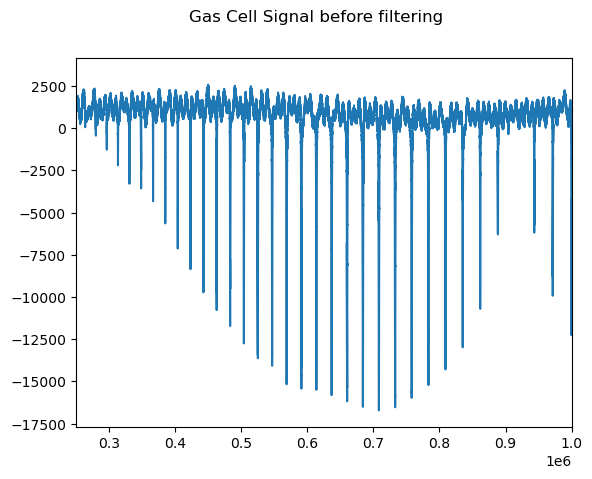

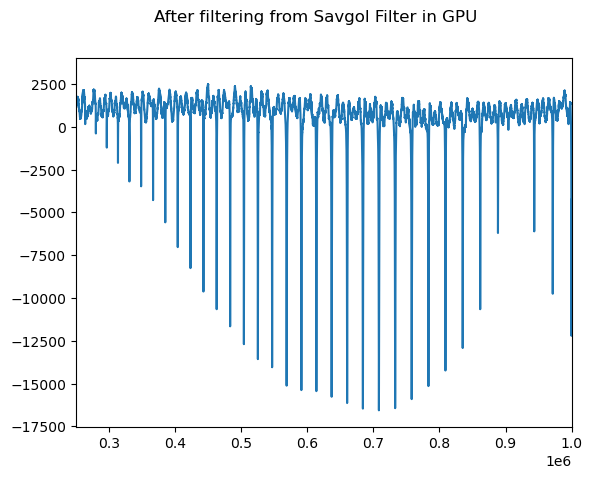

--- Time to filter with Savgol for Gas Cell on CPU 0.22041106224060059 seconds ---


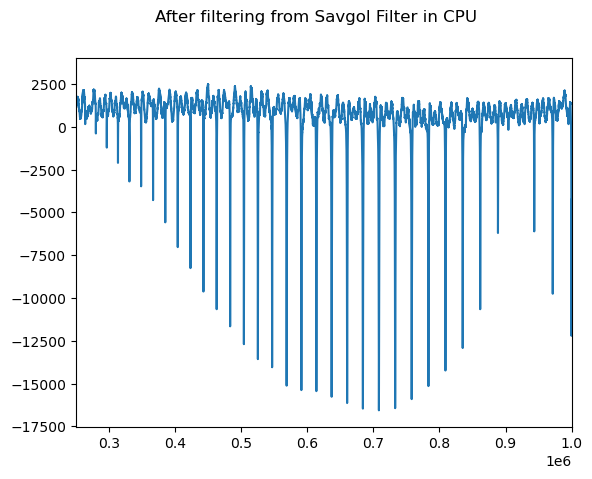

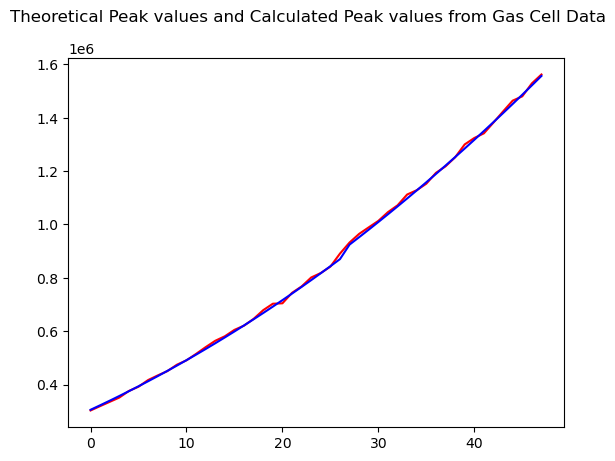

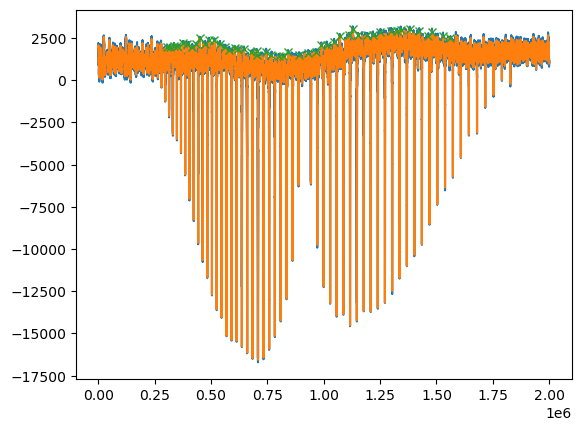

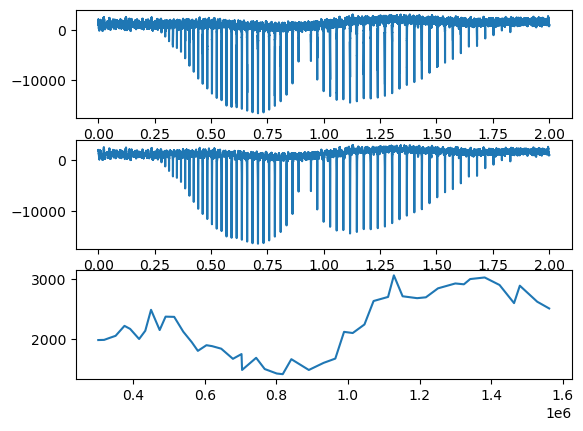

In [166]:
'Main Function for Linearization'

externalData = np.load('data/fsiDataForTomek.npy', allow_pickle=True)

rawData = { 
    'Measurement int'   : externalData[1], # Raw data from the measurement interferometer 
    'Gas cell'          : externalData[2],
    'Reference int'     : externalData[0],
    'Time interval'     : externalData[3]
}


class FsiSignalParams:
    def __init__(self, CHAN_NUM = 0, CURRENT_DISTANCE = 0.5, DISTANCE_WINDOW = 0.01, PICO_V_RANGE = PICO_RANGE.R200MV, ERROR_COUNTER = 0, FBG = False):
        self.distanceWindow    = DISTANCE_WINDOW    # Distance around center value for the fitting window 
        self.currentDistance   = CURRENT_DISTANCE   # Current value of distance measurement
        self.chanNumber        = CHAN_NUM           # Channel number
        self.picoRange         = PICO_V_RANGE       # Current voltage range of the PicoScope channel
        self.errorCounter      = ERROR_COUNTER      # Error counter
        self.fbg               = FBG                # Defines whether the channel is a Fiber Bragg Grating sensor of an FSI sensor (Boolean)


fsiParamsHandle = FsiSignalParams(2, [0.131594], 0.001, PICO_RANGE.R200MV, 0, False)

class GlobalConfig:
    setupOpMode         = SETUP_OP_MODE.NORMAL              # Setup operation mode
    resultsFileName     = 'Test.csv'                        # Name and path to the file where the measurement results are saved
    externalRawData     = 'Debug\\TestLabViewSecond.mat'    # Name and path to a file containing raw data for analysis (TEST_MODE only!)
    laserParams         = initCfg.LaserInitParams           # Laser configuration
    picoParams          = initCfg.PicoScopeInitParams       # PisoScope configuration
    edfaParams          = initCfg.EdfaInitParams            # EDFA configuration
    foSwitchParams      = initCfg.FoSwitchInitParams        # Fiber optic switch configuration
    photoModuleParams   = initCfg.PhotoModuleInitParams     # Photodetection module configuration
    computationConfig   = initCfg.ComputationConfig         # Configuration of the computation algorithm

    
zpf   = 1
nAir = 1.0

Tinterval = rawData['Time interval']
print(rawData['Time interval'])
print('Sampling rate: ' + str((1/rawData['Time interval'])/1e6) + ' MSPS') 
REF_IM = rawData['Reference int']
start_time = time.time()
REF_IM = filterDataButterworthHighpass(rawData['Reference int'],100000,800000000)
print("--- Time for ButterWorth HP on GPU %s seconds " % (time.time() - start_time))
Time_GPU_BW = time.time() - start_time

start_time = time.time()
Gas_Linear, Meas_Linear =  DataLinearize(rawData['Time interval'], rawData['Reference int'], rawData['Gas cell'], rawData['Measurement int']) 

print("--- Time to Linearize %s seconds ---" % (time.time() - start_time))

'Gas Cell Peak Detection'

retStatus = {}

processedDataStorage = {}          #Dictionary to store output data

cLight      = 299792458                                 # Speed of light in m/s


start_time=time.time()
processedDataStorage['Filtered gas cell out'] = savgol_filter_gpu(Gas_Linear, window_size=101, order=2)  # Signal filtering - Savitzky-Golay filter
Time_GPU_Savgol = time.time() - start_time
print("--- Time to filter with Savgol for Gas Cell on GPU %s seconds ---" % (Time_GPU_Savgol))

Gas_Linear = cp.asnumpy(Gas_Linear)
Meas_Linear = cp.asnumpy(Meas_Linear)
plt.plot(Gas_Linear)
x = np.arange(0,2000000, 1)
plt.suptitle('Gas Cell Signal before filtering')
plt.xlim(250000,1000000)
plt.show()

processedDataStorage['Filtered gas cell out'] = cp.asnumpy(processedDataStorage['Filtered gas cell out'])
plt.plot(processedDataStorage['Filtered gas cell out'])
plt.suptitle('After filtering from Savgol Filter in GPU')
plt.xlim(250000,1000000)
plt.show()

start_time=time.time()
processedDataStorage['Filtered gas cell out'] = savgol_filter(Gas_Linear, 101, 2, mode='interp') # Signal filtering - Savitzky-Golay filter
Time_CPU_Savgol = time.time() - start_time
print("--- Time to filter with Savgol for Gas Cell on CPU %s seconds ---" % (Time_CPU_Savgol))
plt.plot(processedDataStorage['Filtered gas cell out'])
plt.suptitle('After filtering from Savgol Filter in CPU')
plt.xlim(250000,1000000)
plt.show()

processedDataStorage['Gas cell peak idxs'], retStatus['Gas cell'] = gasCellFindPeaks_gpu(processedDataStorage['Filtered gas cell out'], GlobalConfig.picoParams, GlobalConfig.laserParams, 'pyfsi/SRM2519a.csv')  # Beta test

GAS_CELL_wavelengths = np.genfromtxt('SRM2519a.csv')                 # Load reference data for the gas cell used (NIST)
GAS_CELL_wavelengths = GAS_CELL_wavelengths*1e-9                            # Convert to m
GAS_CELL_spectrum = cLight/GAS_CELL_wavelengths                             # Convert reference spectral data to frequency
GAS_CELL_spectrum_time = processedDataStorage['Gas cell peak idxs']*rawData['Time interval']                  # Calculate peak occurence times in the measured gas cell signal
    
alpha = np.polyfit(GAS_CELL_spectrum_time, GAS_CELL_spectrum,1)             # Calculate the real sweep speed (linear fit)
alpha = alpha[0]


#print(processedDataStorage['Gas cell peak idxs'])


'Gas Cell Peak plots'

plt.plot(Gas_Linear)
plt.plot(processedDataStorage['Filtered gas cell out'])
plt.plot(processedDataStorage['Gas cell peak idxs'], processedDataStorage['Filtered gas cell out'][processedDataStorage['Gas cell peak idxs']], 'x')
plt.show()



fig2 = plt.figure()
plt.subplot(3,1,1)
plt.plot(Gas_Linear)
plt.subplot(3,1,2)
plt.plot(processedDataStorage['Filtered gas cell out'])
plt.subplot(3, 1, 3)
plt.plot(processedDataStorage['Gas cell peak idxs'], processedDataStorage['Filtered gas cell out'][processedDataStorage['Gas cell peak idxs']])
plt.show()






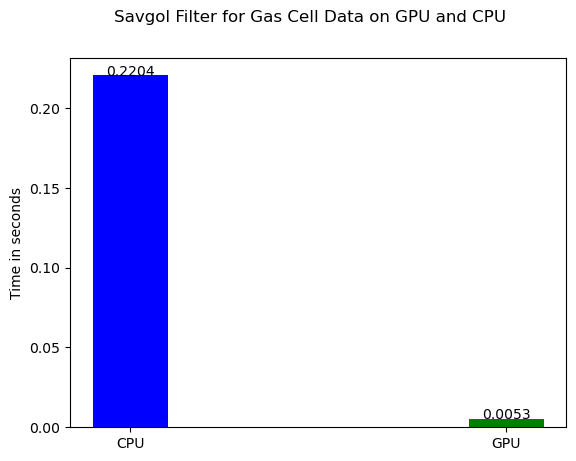

In [167]:
'Execution Time Plots for Savgol Filter for Gas Cell Data'

colors=['blue', 'green']
names = ['CPU', 'GPU']
x_hist=[Time_CPU_Savgol,Time_GPU_Savgol]
x= [0,1]

plt.bar(x, x_hist, width=0.2, align='center', color=colors)
plt.xticks(x,names)
plt.ylabel('Time in seconds')
plt.suptitle('Savgol Filter for Gas Cell Data on GPU and CPU')
for i in range(len(x_hist)):
        plt.text(i,x_hist[i],str("%.4f" %x_hist[i]), ha='center')
plt.show()